# Logistic Regression (an example)

<div style="text-align: right;">
    <a href="logistic_regression.ipynb">このページのオリジナルのipynbファイル</a><br/>
    <a href="index.html">ホームへ戻る To homepage</a>
</div>

これまで扱ってきたデータは、説明変数に対する目的変数の値は、平均値の周りにガウス分布すると想定してきました。

(参考：PRML 図1.16)

<img src="https://8tops.yamanashi.ac.jp/~toyoki/lectures/simulationMethods/images/prmlfigs-png/Figure1.16.png" width="400"/>

しかし、目的変数に上限、下限がある場合は、平均値が上限、下限に近いときガウス分布するとは言えません。

典型例としてよく紹介されるのは、学習時間を説明変数、試験の合否を目的変数にとるような場合です。この場合、目的変数は２値ですが、同じ時間勉強しても合格者も不合格者も一定割合ででるでしょう。その確率分布はどのようになるか、また合格可能性を勉強時間の関数とした数値で表すにはどうしたらよいでしょう。

[WikipediaのLogistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)では、その例が載っています。

![A graph of Logistic Regression](https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg)

<span style="color:blue">合格可能性を$p$</span> とすると合格者数の分布は次のような二項分布になると想定されます。このような場合は、サンプル集団の合格者数分布は合格可能性曲線の上下でガウス分布のような対称な形とはなりません。その意味では「平均」としての合格可能性の意味には慎重な解釈が必要になります。
(この図(ヒストグラム)を作成するプログラムは、下の「参考」に掲載。)

![２項分布](images/binomial_max10.png)


同じような問題ですが、

この授業では、生態学でのサンプルデータを扱ってみます。

「データ解析のための統計モデリング入門」（久保拓弥、岩波）の著者ページにリンクがある、著者の講義ノート
https://kuboweb.github.io/-kubo/ce/EesLecture2008.html#toc5
からの引用です。

上記ページでは統計処理言語Rのプログラム例が載っていますが、ここではpythonで分析を試みます。


## サンプルデータ

ある植物の種が発芽するかどうかは、植物個体の大きさとその植物に施肥したかどうかによるかどうかを分析します。(データは仮想のものです。)

<dl>
    <dt>目的変数: 発芽した種子数(y)</dt>
    <dd>各個体からとったN個の種子のうち発芽した数(データではすべてN=8)
    </dd>
    <dt>説明変数</dt>
    <dd>
        <ul>
            <li> 個体(親)の大きさ( <strong>x</strong> )</li>
            <li> 個体に施肥(fertilization)したかどうかの2値( <strong>f</strong> )</li>
        </ul>
    </dd>
</dl>

まずは、データは、上記ページにある"data4a.csv"です。次のURLよりダウンロードし、各自のスクリプトで読めるところにおいてください。

https://kuboweb.github.io/-kubo/stat/2008/d/fig/data4a.csv

これをpandasのDataFrameに読み込んで使います。

(注)
1. Google colabでのファイルの扱いについては、プレ授業用の資料を参照してください。
   https://colab.research.google.com/drive/1aFaB9KzxKjkiyiwgME2wKcmpQ7yMFHRs?usp=sharing
2. 下のセルのでコメントアウトした行のようにkuboのページにあるソースのURLを直接指定して読み込むことも可能です。


In [12]:
# You need to put the csv file in your own folder downloaded from
# https://kuboweb.github.io/-kubo/ce/EesLecture2008.html#toc5 
import pandas as pd
#df = pd.read_csv("data/data4a.csv")
# Alternatively, you can use kubo's data directly through URL
df = pd.read_csv("https://kuboweb.github.io/-kubo/stat/2008/d/fig/data4a.csv")
df

N  y      x  f
0   8  1   9.76  C
1   8  6  10.48  C
2   8  5  10.83  C
3   8  6  10.94  C
4   8  1   9.37  C
.. .. ..    ... ..
95  8  7  10.45  T
96  8  0   8.94  T
97  8  5   8.94  T
98  8  8  10.14  T
99  8  1   8.50  T

[100 rows x 4 columns]

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAGothic' # Linux上で日本語フォントを扱う場合
# plt.rcParams['font.family'] = 'MS Gothic' # Windowsで日本語フォントが使えないとき利用
df_C = df[df['f']=='C'] # extract df['f'] == 'C'
df_T = df[df['f']=='T']

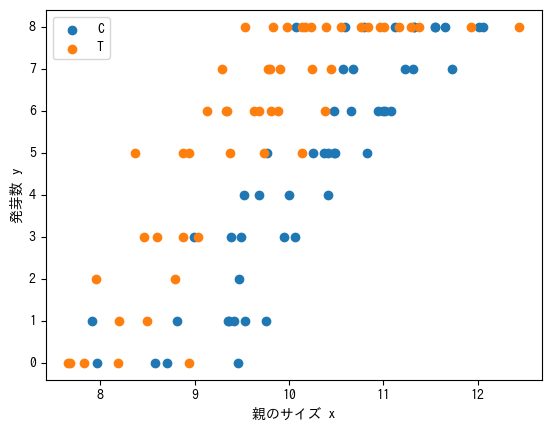

In [18]:
plt.scatter(df_C['x'], df_C['y'], label="C")
plt.scatter(df_T['x'], df_T['y'], label="T")
plt.legend()
plt.xlabel("親のサイズ x")
plt.ylabel("発芽数 y")
plt.show()

## scikit-learnでのLogistic Regression

$f(x)\rightarrow 1\ {\rm as\ } x \rightarrow \infty$、$f(x)\rightarrow 0\ {\rm as\ } x \rightarrow -\infty$のような関数の典型例はlogistic functionと呼ばれます。($\tanh$関数のスケール変換したものと同じです。)

$$
 f(x) = \frac{1}{1 + e^{-x}} = \frac{1}{2}\left(1 + \frac{e^{x/2} - e^{-x/2}}{e^{x/2} + e^{-x/2}}\right) =
 \frac{1}{2}\left(1 + \tanh (x/2) \right)
 $$

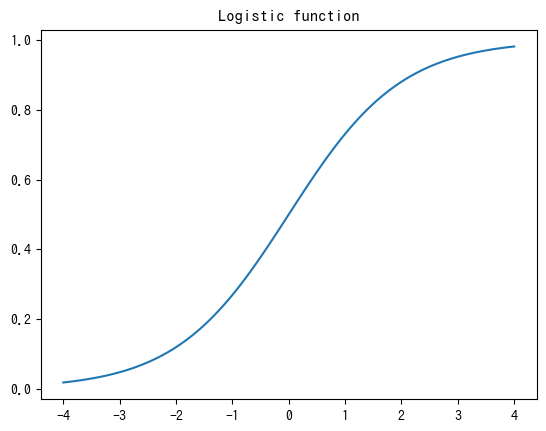

In [16]:
import numpy as np

x = np.linspace(-4,4,100)
y = 1. /(1. + np.exp(-x))
plt.plot(x,y)
plt.title("Logistic function")
plt.show()


この曲線に近似するのがLogistic Regressionですが、上の例のように、目的変数は合格か不合格かの２値であるような問題に適用される場合が多いためか、sciki-learn の Logistic Regression モジュールは、regressorsではなくclassifiersのカテゴリに入っています。

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

Logistic Regression は、多くの場合、２値問題（ある事象が起こるか起こるか）を説明変数から推定する場合に用いられます。

ここでの例でも、あるサイズの親から取った種が発芽するかしないかの確率を求める問題といってもよくその意味ではクラス分け問題に属するのですが、データの与え方が異なります。

各行が８個中何個が発芽したかが目的変数になるので、単純にここで読み込んだデータフレームを渡すと、各行が９種類にカテゴライズされるという結果になります。

以下ではそれを確かめてみます。

本来のlogistic regressionを行うためのモジュールはscikit-learnにはないようなので、あとで、もう一つの統計モジュールであるstatsmodelsを使ってみます。

In [21]:
from sklearn.linear_model import LogisticRegression
lr_C = LogisticRegression(max_iter=500)
lr_T = LogisticRegression(max_iter=500)

lr_C.fit(df_C[['x']], df_C['y']) # explanation variables (features) are an array
lr_T.fit(df_T[['x']], df_T['y'])
# warning will be returned but you will get resultant learned machines

LogisticRegression(max_iter=500)

本来、予測したいことは、与えられたサイズの親から採取した種が発芽する確率ですが、ここでは親のサイズと８個中何個が発芽するかのデータなので、結果も0個から8個までそれぞれの確率が得られます。

まずは、確率が最大になる個数を図示してみます。
その値は、predict関数に、引数としてサイズを与えることにより得られます。

In [25]:
# 親のサイズに対する発芽数予測：predict bud-break number for a given parent-size
import numpy as np
x_test = np.linspace(6,12.0, 200)
predicted_C = lr_C.predict(x_test[:, np.newaxis])
predicted_T = lr_T.predict(x_test[:, np.newaxis])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


最大確率をもつ個数をプロットすると次のようになります。

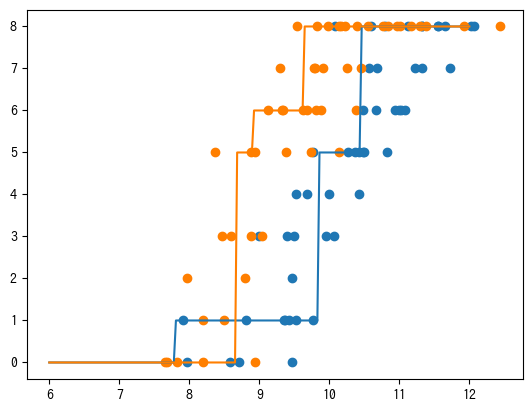

In [26]:
# Predicted value versus the bud-break number in eight
# predicted value is one with the highest probablity
plt.scatter(df_C['x'], df_C['y'])
plt.plot(x_test, predicted_C)
plt.scatter(df_T['x'], df_T['y'], color='#ff7f00')
plt.plot(x_test, predicted_T, color='#ff7f00')
plt.show()

確率分布はpredict_probaにより得られます。

In [8]:
X=np.linspace(7.0,13.0,5)
prob_C = lr_C.predict_proba(X[:, np.newaxis])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


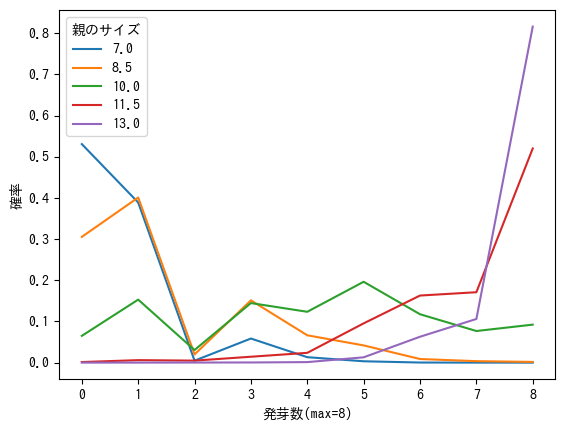

In [20]:
size = np.linspace(0,8,9)
for i, p in enumerate(prob_C):
    plt.plot(size, p, label=X[i])
plt.legend(title="親のサイズ")
plt.xlabel("発芽数(max=8)")
plt.ylabel("確率")
plt.show()

発芽確率を$p$とすると、$N$個中$n$個が発芽する確率は２項分布
$$
P_p(n) = \frac{N!}{n!(N-n)!}p^n(1-p)^{N-n}
$$
になるはずです。

２項分布をいくつかの確率で書いてみると次のようになります。

データから予測された確率分布とはだいぶ異なりますが、これはデータ数の違いによるものでしょう。


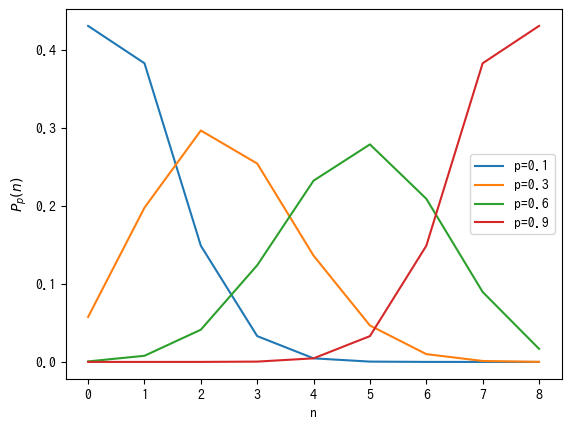

In [21]:
from scipy.stats import binom
plt.plot(size, binom.pmf(size,8,0.1), label="p=0.1")
plt.plot(size, binom.pmf(size,8,0.3), label="p=0.3")
plt.plot(size, binom.pmf(size,8,0.6), label="p=0.6")
plt.plot(size, binom.pmf(size,8,0.9), label="p=0.9")
plt.legend()
plt.xlabel("n")
plt.ylabel("$P_p(n)$")
plt.show()

あるサイズ（横軸）に対して確率が二項分布になることを想定した回帰をscikit-learnで「直接」行う関数があるかもしれませんが、見つけられませんでした。


## statsmodelsによる回帰分析

statsmodelsはRでの書式を用いる仕様になっているので、Rをよく知っている人、Rと併用したい人には使いやすいものとなっています。

久保のテキストを参考に、statsmodelsを使ってみます。

引数 **formula** に与える式がR独特のものでわかりにくいのですが、
- チルダ"~"の左が目的変数、右が説明変数
- "+"は足し算ではなく、複数の変数をセットするという意味
- I()は独立変数としてセットするという意味

と解釈してください。

In [27]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
N=8
# 説明変数x及びf、目的変数yが起こる確率pと、1-pとの関係を二項分布だとしてフィッティング
model = smf.glm(formula='y + I(N-y) ~ x + f', 
                data=df, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Wed, 26 Jul 2023   Deviance:                       123.03
Time:                        11:12:56   Pearson chi2:                     109.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9768
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.0

In [10]:
model

In [28]:
df['predict'] = result.predict() # xに対する予測値を列に加える

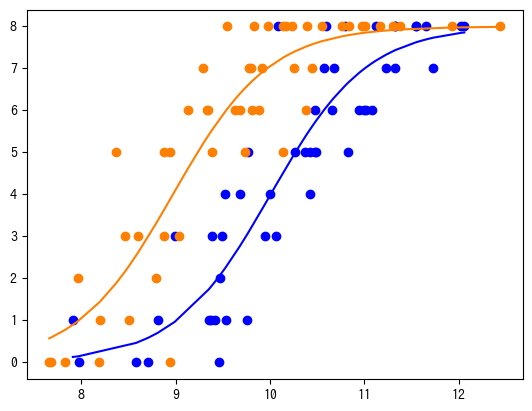

In [29]:
# 描画
df_C = df[df['f']=="C"].sort_values('x')
df_T = df[df['f']=="T"].sort_values('x')
plt.scatter(df_C['x'], df_C['y'], color='b') # データ点の描画
plt.plot(df_C['x'], df_C['predict']*8.0, color='b') # 予測(推定)曲線の描画
plt.scatter(df_T['x'], df_T['y'], color='#ff7f00')
plt.plot(df_T['x'], df_T['predict']*8.0, color='#ff7f00')
plt.show()

説明のために二項分布の図を載せます。
![二項分布](https://8tops.yamanashi.ac.jp/~toyoki/lectures/PracDataSci/images/binomial4.png)

# Poisson Regression

前節で扱ったのは、目的変数の値に上限、下限がある問題でした。その場合、分布は2項分布になることが予想されます。

ここでは、下限が0で、上限が存在しないようなデータについて考えてみます。

0付近に多くが分布するような場合は、Poisson分布を仮定した分析も検討すべきです。

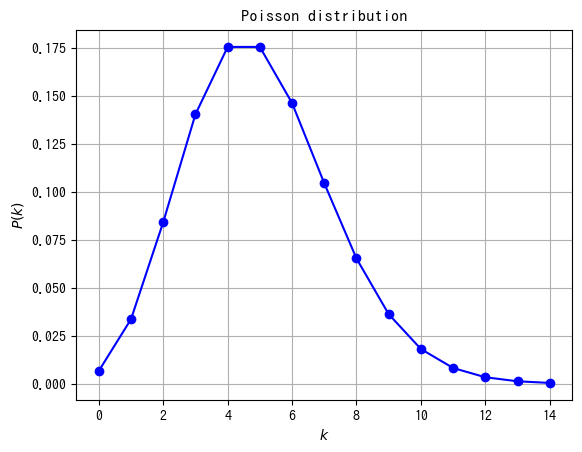

In [30]:
# Poisson分布の描画
import numpy as np
from scipy.stats import poisson
# 平均値
m=5
# 描画範囲
x = np.arange(0, m*3)
# ポアソン分布
y = poisson.pmf(x, m)

# FigureとAxes
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.set_title("Poisson distribution")
ax.set_xlabel("$k$")
ax.set_ylabel("$P(k)$")
# データをプロット
ax.plot(x, y, marker="o", color="blue")
plt.show()

## 事例：橋を通行する自転車数と気温、雨量の関係

次のページを参考に Poisson Regression の例を試してみましょう。

授業で少し説明しますが、ブルックリン橋を通行する自転車の数を目的変数に、最低気温、最高気温、雨量を説明変数にしたデータをポアソン回帰で分析した例です。


https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/scikit-learn%E3%81%A7%E3%81%AE%E3%82%AB%E3%82%A6%E3%83%B3%E3%83%88%E3%83%87%E3%83%BC%E3%82%BF%E4%BA%88%E6%B8%AC%E3%81%99%E3%82%8B%E3%83%9D%E3%83%AF%E3%82%BD%E3%83%B3%E5%9B%9E%E5%B8%B0/

このページのスクリプト例では、
橋を渡る自転車の台数に関するNYCのオープンデータに説明変数の諸量をくわえたgithub上の公開データ(次のURL)を参照しています。CSVデータをダウンロードしておいて、それを参照するスクリプトになっています。

https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/

次のようにURLを指定して直接読み込む方が楽です。(colabでは特に。)


In [32]:
import pandas as pd
# data url
url = "https://gist.githubusercontent.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv"
bike_data = pd.read_csv(url)
bike_data["Date"] = pd.to_datetime(bike_data["Date"]) # 文字列をDatetime型に変換
bike_data["DOW"] = bike_data["Date"].dt.dayofweek
bike_data["MONTH"] = bike_data["Date"].dt.month
bike_data


Date  HIGH_T  LOW_T  PRECIP  BB_COUNT  DOW  MONTH
0   2017-04-01    46.0   37.0    0.00       606    5      4
1   2017-04-02    62.1   41.0    0.00      2021    6      4
2   2017-04-03    63.0   50.0    0.03      2470    0      4
3   2017-04-04    51.1   46.0    1.18       723    1      4
4   2017-04-05    63.0   46.0    0.00      2807    2      4
..         ...     ...    ...     ...       ...  ...    ...
209 2017-10-27    62.1   48.0    0.00      3150    4     10
210 2017-10-28    68.0   55.9    0.00      2245    5     10
211 2017-10-29    64.9   61.0    3.03       183    6     10
212 2017-10-30    55.0   46.0    0.25      1428    0     10
213 2017-10-31    54.0   44.0    0.00      2727    1     10

[214 rows x 7 columns]

交通量は曜日によると考えて、"DOW" (Day of Week)を入れてみる。

Newral NetworkやRandom Forestとの比較も行う。

In [33]:
features = bike_data[["HIGH_T", "LOW_T", "PRECIP", "DOW"]]
targets = bike_data["BB_COUNT"]

# 訓練データとテストデータへの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=0)

# データの正規化
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [34]:
# models
models = {} # 学習機械
predict_obs = {} # テストデータの推定結果

# (1) 線形重回帰
from sklearn.linear_model import LinearRegression
models["Linear"] = LinearRegression()

# (2) ポアソン回帰
from sklearn.linear_model import PoissonRegressor
models["Poisson"] = PoissonRegressor()

# (3) ニューラルネット
from sklearn.neural_network import MLPRegressor
models["NeuralNetwork"] = MLPRegressor(max_iter=5000)

# (4)ランダムフォレスト回帰
from sklearn.ensemble import RandomForestRegressor
models["RandomForest"] = RandomForestRegressor()

# 学習とテストデータの推定
for k,m in models.items():
    # 学習
    m.fit(X_train, y_train)
    # テストデータでの予測(推定)
    result = m.predict(X_test)
    predict_obs[k] = {"obs": np.array(list(y_test)), "predict": result}


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
# 決定係数
from sklearn.metrics import r2_score
for k,r in predict_obs.items():
    print("model: %s,  R2=%.3f" % (k, r2_score(r["obs"], r["predict"])))

model: Linear,  R2=0.356
model: Poisson,  R2=0.385
model: NeuralNetwork,  R2=0.211
model: RandomForest,  R2=0.433


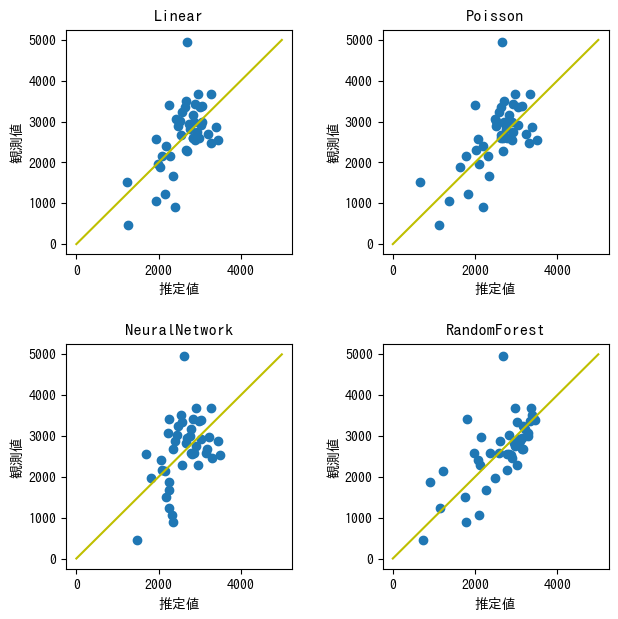

In [36]:
fig = plt.figure(figsize=(7,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4) # これがないと軸ラベルが重なってしまう
fig_no = 1
for k,r in predict_obs.items():
    ax = fig.add_subplot(2,2,fig_no)
    ax.scatter(r["predict"], r['obs'])
    ax.plot([0,5000],[0,5000], "y")
    ax.set_title(k)
    ax.set_xlabel("推定値")
    ax.set_ylabel("観測値")
    fig_no = fig_no+1
                              

決定係数は、ポアソン回帰の方が線形重回帰よりよいが、Random Forestがもっともよくなっています。

余裕がある人はいろいろなパラメータ設定で試してみてください。

このデータでは、極めて少ない通行量（数台とか）の日がないので、必ずしもポアソン分布するデータとして扱う必要はないと言えそうです。

## 参考

上掲の二項分布の作図をプログラムをつけておきます。

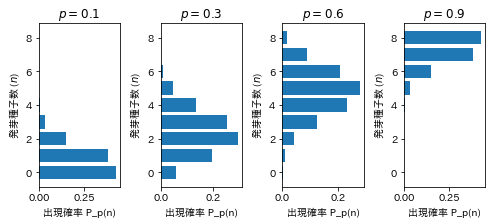

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
size = np.linspace(0,8,9)
fig = plt.figure(figsize=(8,3))
plt.subplots_adjust(wspace=0.5)
for i, p in enumerate([0.1, 0.3, 0.6, 0.9]):
    ax = fig.add_subplot(1, 4, i+1) 
    ax.barh(size, binom.pmf(size,8,p), label="p=" + str(p))
    ax.set_ylabel("発芽種子数 ($n$)")
    ax.set_xlabel("出現確率 P_p(n)")
    ax.set_title("$p=" + str(p) + "$")
fig.savefig("images/binomial4.png", bbox_inches='tight')
plt.show()

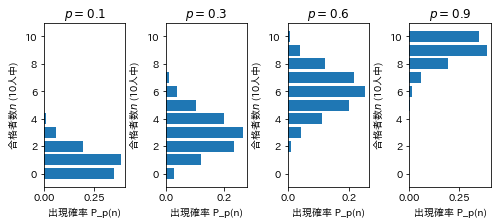

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
size = np.linspace(0,10,11)
fig = plt.figure(figsize=(8,3))
plt.subplots_adjust(wspace=0.5)
for i, p in enumerate([0.1, 0.3, 0.6, 0.9]):
    ax = fig.add_subplot(1, 4, i+1) 
    ax.barh(size, binom.pmf(size,10,p), label="p=" + str(p))
    ax.set_ylabel("合格者数$n$ (10人中)")
    ax.set_xlabel("出現確率 P_p(n)")
    ax.set_title("$p=" + str(p) + "$")
fig.savefig("images/binomial_max10.png", bbox_inches='tight')
plt.show()

これまで、目的変数が有限な範囲$[0,8]$を取る場合を見てきましたが、データによっては範囲が$[0,\infty )$で、値がそれぞれ整数値、連続値の場合もあります。

そのような場合は、それぞれPoisson分布、ガンマ分布に従っていると想定して分析することが良く行われています。

久保のテキストでは、前者の例として、ある植物の体の大きさと種の個数の関係、後者として葉の重量と花の重量の関係のデータを扱っています。